# Initialization

This notebook contains commands for all necessary preparations between training models:

- concatenate data into 3 datasets (train, test1, test2);
- produce labels for cross-validation

Note: indices for train/test splits are already provided with this repository, but user may recompute it.

### Data preparation

Filter inappropriate samples (blanks, etc) from dataset, map labels of low-sampled identities to '-1' class.

In [1]:
import numpy as np
import sys
sys.path.append('../src/')

from initialization import concatenateSeparateToOneDF
from initialization import filterLabels

dirname = '../data/'
save_filename = 'dataset'
save_filename2 = 'test2'
save_filename_without_moc = 'dataset_without_moc'

main_dataset_filename = 'LCMS-IT-TOF.npz'

filterLabels(main_dataset_filename, dirname, min_count=20, save_filename=save_filename)
print "<%s> successfully filtered into <%s>" % (main_dataset_filename, save_filename)

additional_dataset_filenames = [
    'LCMS-IT-TOF_water.npz', 'LCMS-IT-TOF_methanol.npz', 
    'Agilent_QqQ_water.npz', 'Agilent_QqQ_methanol.npz', 'Agilent_QqQ_ethanol.npz'
]

concatenateSeparateToOneDF(additional_dataset_filenames, dirname, save_filename2)
print "<%s>: successfully concatenated." % (save_filename2)

filterLabels(main_dataset_filename, dirname, min_count=1, save_filename=save_filename_without_moc)
print "<%s>: successfully filtered into <%s>." % (main_dataset_filename, save_filename_without_moc)

<LCMS-IT-TOF.npz> successfully filtered into <dataset>
<test2>: successfully concatenated.
<LCMS-IT-TOF.npz>: successfully filtered into <dataset_without_moc>.


In [11]:
df = np.load(dirname+save_filename_without_moc+'.npz')
#df = np.load(dirname+main_dataset_filename)
l = df['label']
print len(np.unique(l))

76


### Cross validation index generation

Generate indices for repeated K-fold CV.

In [2]:
import numpy as np
import os
import sys
sys.path.append('../src/')

from initialization import concatenateSeparateToOneDF
from initialization import filterLabels
from initialization import generateRandomizedKFoldedSet

dirname = '../data/'
filename = 'dataset.npz'
filename_cv = 'cv_indices'

n_splits = 5
n_repeats = 5
# next variable must guarantee the quivalence of generated splits and ones used in our research
random_state = 235

try:
    df = np.load(dirname+filename)
    X, y = df['data'], df['label']
    i1, i2 = generateRandomizedKFoldedSet(
        X, y, n_splits, n_repeats, random_state, filename_cv,
        dirname, return_result=1
    )
    print '%d-times repeated %d-fold splits are generated and saved to <%s> in <%s> directory' % (
        n_repeats, n_splits, filename_cv, dirname
    )
except:
    print "No file %s in %s directory." % (filename, dirname)
    print "Please run data preparation code from above section ."

5-times repeated 5-fold splits are generated and saved to <cv_indices> in <../data/> directory


### Cross validation index generation: predict part of plants

Generate indices for repeated K-fold CV.

In [3]:
import numpy as np
import sys
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
sys.path.append('../src/')

dirname = '../data/'
filename_without_moc = 'dataset_without_moc.npz'
filename_without_moc_parts = 'dataset_parts.npz'
filename_test2 = 'test2.npz'
filename_test2_parts = 'test2_parts'
filename_without_moc_parts_cv = 'cv_indices_parts'
species_filename = 'species.csv'

n_splits = 5
n_repeats = 5
# next variable must guarantee the quivalence of generated splits and ones used
# in our research
random_state = 235

try:
    df = pd.read_csv(dirname+species_filename, header=None)
    labelMapper = {}
    for k in xrange(len(df)):
        labelMapper[df.iloc[k, 0]] = df.iloc[k, 2]
except:
    print "No file %s in %s directory." % (species_filename, dirname)

try:
    df = np.load(dirname+filename_without_moc)
except:
    print "No file %s in %s directory." % (filename_without_moc, dirname)
    print "Please run data preparation code from above section ."
    
    
X, y = df['data'], df['label']
y_new = map(lambda x: labelMapper[x], y)
labelEncoder = LabelEncoder()
y_new = labelEncoder.fit_transform(y_new)
class_names = labelEncoder.classes_
np.savez_compressed(
    dirname+filename_without_moc_parts, data=X, label=y_new
)

try:
    df = np.load(dirname+filename_test2)
except:
    print "No file %s in %s directory." % (filename_test2, dirname)
    print "Please run data preparation code from above section ."

Xtest2, ytest2 = df['data'], df['label']
ytest2_new = map(lambda x: labelMapper[x], ytest2)
ytest2_new = labelEncoder.transform(ytest2_new)
class_names = labelEncoder.classes_
np.savez_compressed(
    dirname+filename_test2_parts, data=Xtest2, label=ytest2_new
)


kfold = RepeatedStratifiedKFold(
    n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
)
train_indices = []
test_indices = []
for train_index, test_index in kfold.split(X, y_new):
    train_indices.append(train_index)
    test_indices.append(test_index)

np.savez_compressed(
    dirname+filename_without_moc_parts_cv, n_splits=n_splits, n_repeats=n_repeats,
    random_state=random_state,
    train_indices=train_indices, test_indices=test_indices, class_names=class_names
)
print '%d-times repeated %d-fold splits are generated and saved to <%s> in <%s> directory' % (
    n_repeats, n_splits, filename_without_moc_parts_cv, dirname
)

5-times repeated 5-fold splits are generated and saved to <cv_indices_parts> in <../data/> directory


['bark' 'buds' 'flowers' 'fructus' 'leaves' 'roots' 'roots and rhizomes'
 'seeds']
(array(['bark', 'buds', 'flowers', 'fructus', 'leaves', 'roots',
       'roots and rhizomes', 'seeds'], dtype=object), array([ 1,  3,  7,  8, 26, 21,  4,  6]))
(array([0, 1, 2]), array([14, 25, 37]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 12,  48, 150, 193, 688, 745, 167, 260]))
(array([0, 1, 2]), array([898, 453, 912]))


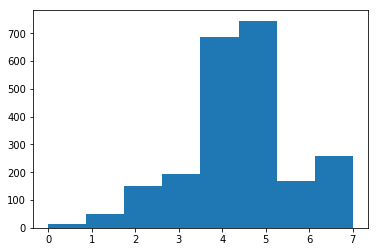

In [45]:
import matplotlib.pyplot as plt

plt.hist(y_new, bins=8)
print class_names
df = pd.read_csv(dirname+species_filename, header=None)
print np.unique(df.iloc[:, -1], return_counts=True)

mapper = {
    'fructus': 0,
    'seeds': 0,
    'roots': 1,
    'roots and rhizomes': 1,
    'bark': 2,
    'buds': 2,
    'flowers': 2,
    'leaves': 2
}

print np.unique(df.iloc[:, -1].map(mapper).values, return_counts=1)

print np.unique(y_new, return_counts=1)
print np.unique(y_new_3, return_counts=1)

In [46]:
labelEncoder3.classes_

array(['aboveground', 'fructus and seeds', 'roots and rhizomes'],
      dtype='|S18')

[Reopen contents](../chemfin.ipynb)